# Задача 2. Линейная регрессия, метод градиентного спуска

## Собственная реализация обучения модели линейной регрессии

Собственная реализация обучения модели линейной регрессии. Используется функция ошибок $MSE + L_2$-регуляризацию.

Данная оптимизирует функционал:
* методом градиентного спуска (Batch Gradient Descent, GD), когда `batch_size=None`
* методом стохастического градиентного спуска (Stochastic Gradient Descent, SGD), когда `batch_size=1`
* методом мини-пакетного градиентного спуска (Mini Batch Gradient Descent), иначе

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

In [ ]:
class MyRidge(BaseEstimator):
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=None, alpha=1.0):
        self.weights = None
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.c_[np.ones(n_samples), X]

        self.weights = np.random.randn(n_features + 1)

        for iteration in range(self.epochs * n_samples // (n_samples if self.batch_size is None else self.batch_size)):
            if self.batch_size is None:
                X_batch = X
                y_batch = y
            else:
                indices = np.random.choice(n_samples, self.batch_size)
                X_batch = X[indices]
                y_batch = y[indices]
            gradients = 2 / len(y_batch) * X_batch.T @ (X_batch @ self.weights - y_batch)

            regularization_term = 2 / n_samples * self.alpha * self.weights
            gradients[1:] += regularization_term[1:]

            self.weights -= self.learning_rate * gradients

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.weights)


def gradient_descent(X, y, my_estimator: MyRidge):
    my_estimator.fit(X, y)
    return my_estimator.weights

## Набор данных, разведочный анализ и преобразования

В качестве набора данных используется обработанный в [предыдущей работе](https://github.com/IlyaMuravjov/ml-course/blob/main/solutions/task01_eda.ipynb) набор данных World Weather Repository (34 версия).

Целевой признак -- `feel_temperature_diff_celsius` (разница между ощущаемой и фактической температурой в градусах Цельсия).

In [ ]:
df = pd.read_csv('PreparedGlobalWeatherRepository.csv')

Построим гистограммы для всех признаков.

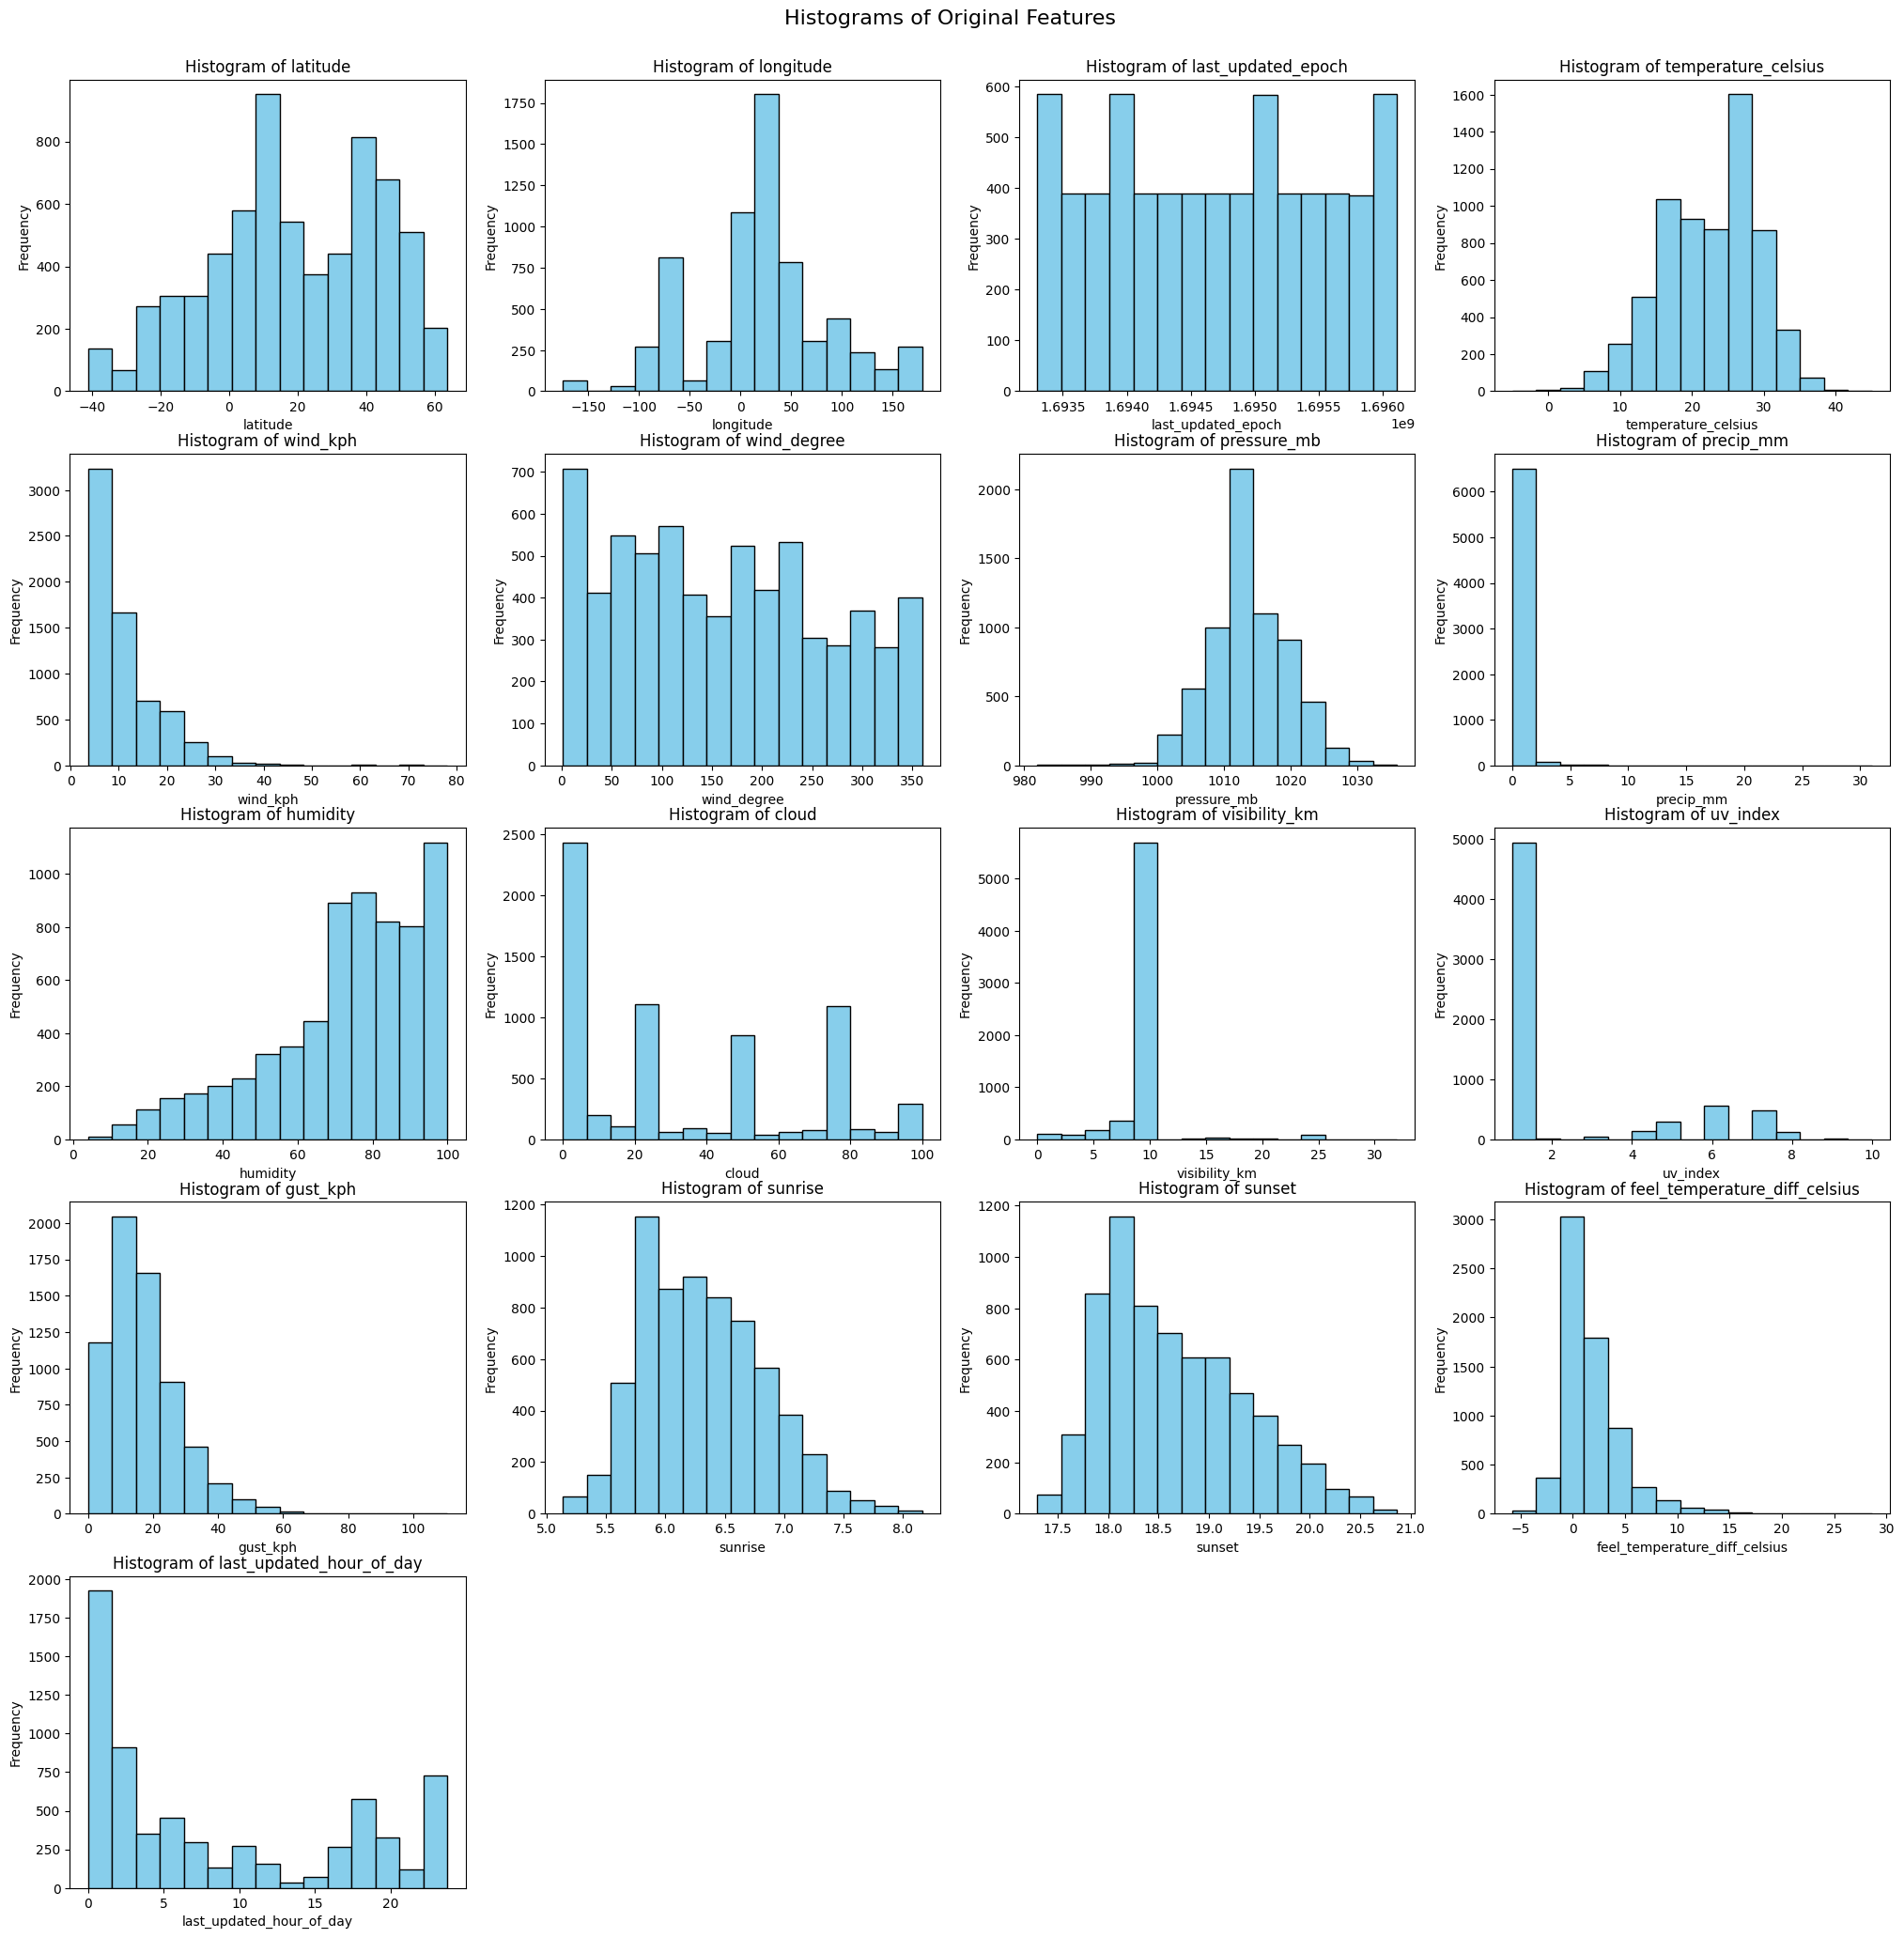

In [ ]:
def plot_histogram_for_every_feature(df, title):
    num_columns = len(df.columns)
    plots_per_row = 4
    num_rows = (num_columns + plots_per_row - 1) // plots_per_row

    fig, axes = plt.subplots(
        nrows=num_rows,
        ncols=plots_per_row,
        figsize=(25, num_rows * 5)
    )

    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        axes[i].hist(df[column], bins=15, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(num_columns, num_rows * plots_per_row):
        fig.delaxes(axes[j])

    fig.suptitle(f"Histograms of {title}", fontsize=16, y=0.91)

plot_histogram_for_every_feature(df, "Original Features")

Разобьём случайным образом данные на обучающую и тестовую выборки.

In [ ]:
y = np.array(df["feel_temperature_diff_celsius"])
X = df.drop(columns=["feel_temperature_diff_celsius"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Проведём масштабирование данных, так как это рекомендуется делать при использовании моделей с регуляризацией. Будем использовать `MinMaxScaler`, так как большинство признаков имеет распределение, отличное от нормального.

In [ ]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

Убедимся, что данные корректно от масштабированы: все признаки тренировочных данные находятся в промежутке $[0, 1]$, а признаки тестовых данных иногда немного выходят за пределы промежутка $[0, 1]$, когда глобальный максимум или минимум признака находится в тестовых, а не тренировочных данных.

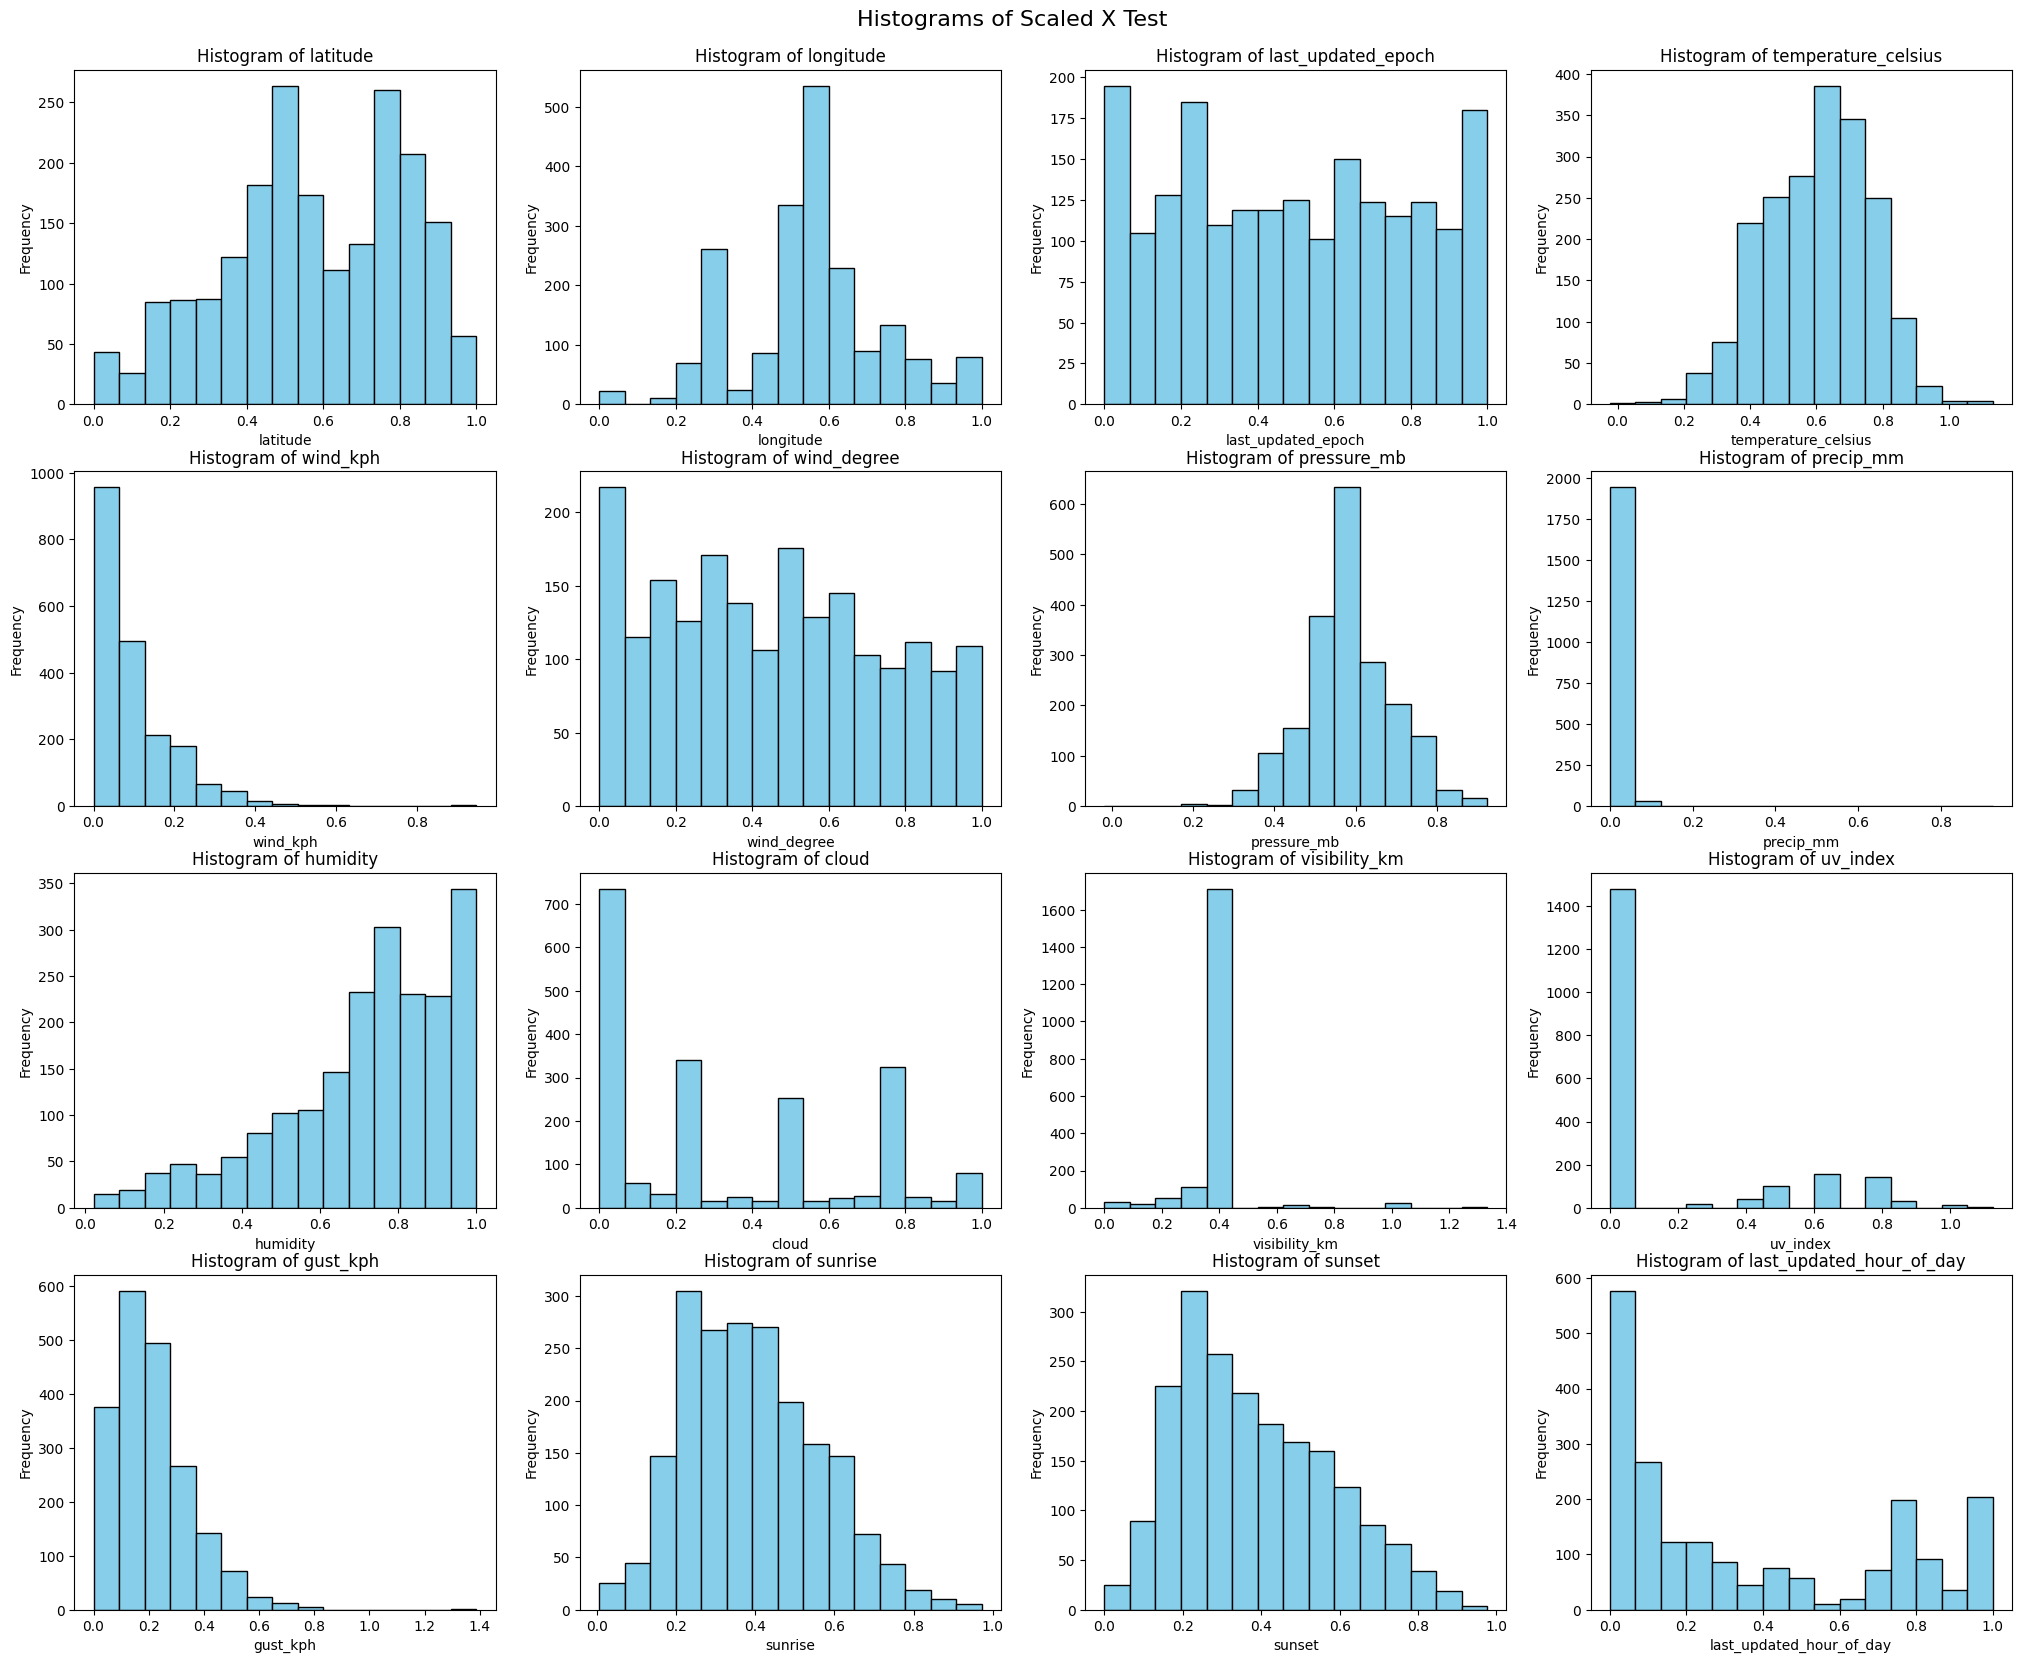

In [ ]:
plot_histogram_for_every_feature(X_train, "Scaled X Train")
plot_histogram_for_every_feature(X_test, "Scaled X Test")

Подберём наилучшее количество (и само подмножество) признаков, используя **Recursive Feature Elimination with cross-validation**.

In [ ]:
rfecv = RFECV(Ridge(), cv=5)
rfecv.fit(X_train, y_train)
selected_features = X.columns[rfecv.support_]
print("Retained features:", set(selected_features))
print("Removed features:", set(X.columns) - set(selected_features))

X = X[selected_features]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Retained features: {'last_updated_hour_of_day', 'temperature_celsius', 'last_updated_epoch', 'uv_index', 'humidity', 'sunset', 'wind_kph', 'sunrise', 'wind_degree', 'precip_mm', 'latitude', 'pressure_mb', 'gust_kph', 'longitude', 'visibility_km'}
Removed features: {'cloud'}


## Создание моделей и метрик

Создадим список метрик для оценки качества модели.

In [ ]:
metrics = [
    ("mse", mean_squared_error),
    ("rmse", lambda y_test, y_test_pred: mean_squared_error(y_test, y_test_pred, squared=False)),
    ("r2", r2_score),
]

Создадим собственные модели линейной регрессии.

In [ ]:
estimators = [
    ("MyRidge GD", MyRidge(batch_size=None)),
    ("MyRidge SGD", MyRidge(batch_size=1, epochs=3)),  # fewer epochs, because SGD is slow due to less vectorization
    ("MyRidge SGD Mini Batch 256", MyRidge(batch_size=256)),
    ("MyRidge SGD Mini Batch 1024", MyRidge(batch_size=1024)),
]

Настроим подбор оптимальных значений гиперпараметров для собственных моделей линейной регрессии.

In [ ]:
grid_search_cv_folds = 5

In [ ]:
alpha_grid = np.logspace(-6, 4, 7)
learning_rate_and_tol_grid = np.logspace(-6, -1, 7)

estimators = [
    (name, GridSearchCV(my_estimator, {
        "alpha": alpha_grid,
        "learning_rate": learning_rate_and_tol_grid
    }, scoring="r2", cv=grid_search_cv_folds))
    for (name, my_estimator) in estimators
]

Добавим модель линейной регрессии из библиотеки **sklearn** и настроим для неё подбор оптимальных значений гиперпараметров.

In [ ]:
estimators += [
    ("Ridge", GridSearchCV(Ridge(), {
        "alpha": alpha_grid,
        "tol": learning_rate_and_tol_grid
    }, scoring="r2", cv=grid_search_cv_folds))
]

## Обучение моделей и оценка их качества

Обучим модели без кросс-валидации и оценим их качество с помощью метрик $MSE$, $RMSE$ и $R^2$.

,MyRidge GD,MyRidge SGD,MyRidge SGD Mini Batch 256,MyRidge SGD Mini Batch 1024,Ridge
mse-train,3.572923,3.543816,3.423394,3.422539,3.418788
mse-test,4.264658,4.230084,4.095525,4.113494,4.099819
rmse-train,1.890218,1.882503,1.850242,1.850011,1.848997
rmse-test,2.065105,2.056717,2.023740,2.028175,2.024801
r2-train,0.545188,0.548893,0.564222,0.564331,0.564809
r2-test,0.514279,0.518217,0.533543,0.531496,0.533053


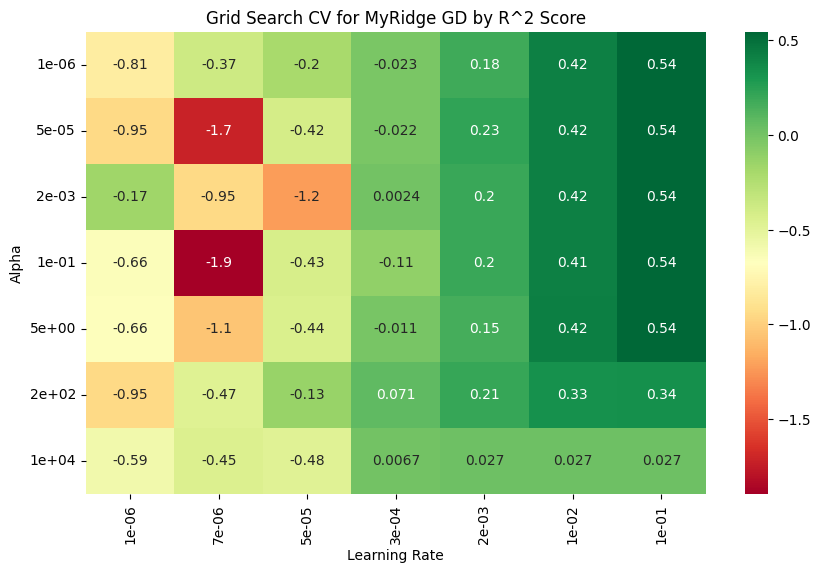

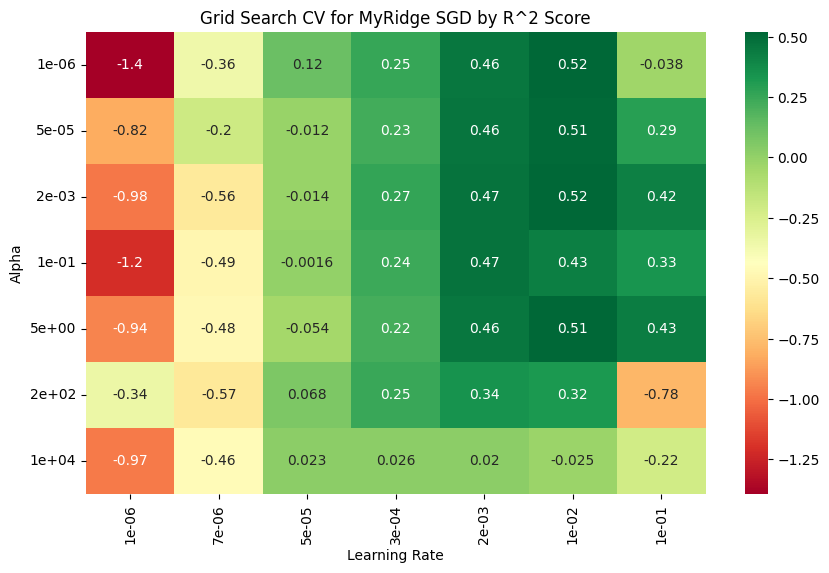

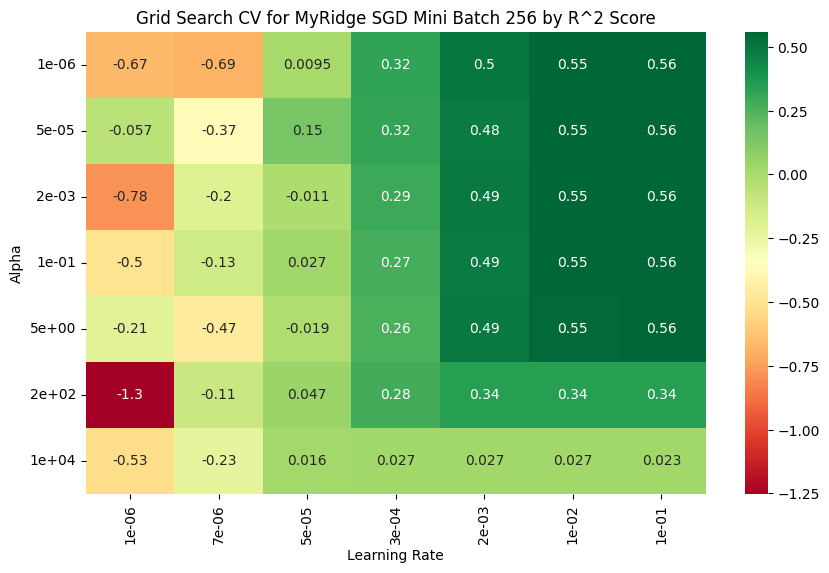

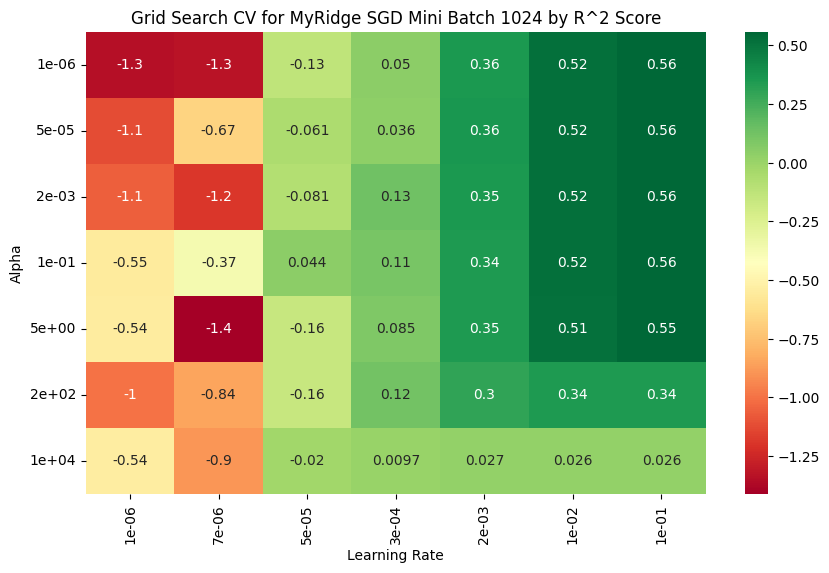

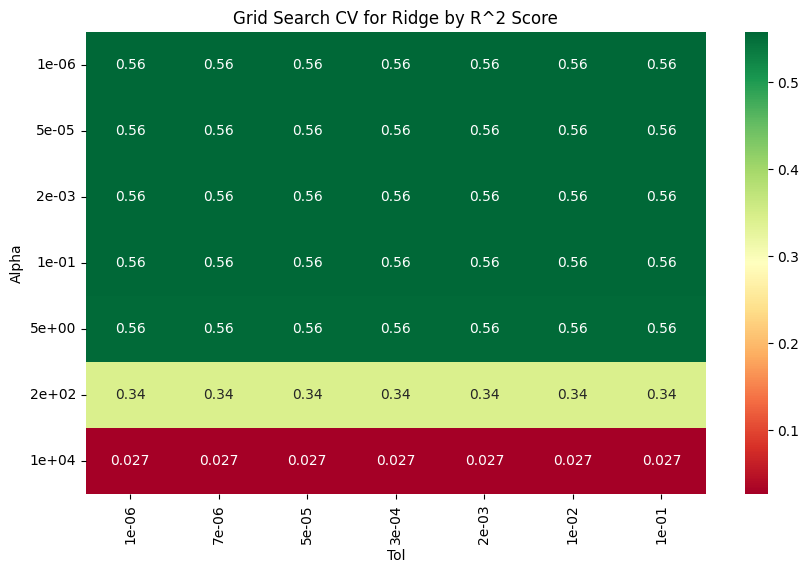

In [ ]:
non_cv_results = pd.DataFrame()
for (estimator_name, estimator) in estimators:
    print(estimator_name)
    estimator.fit(X_train, y_train)

    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)

    for metric_name, metric_func in metrics:
        non_cv_results.loc[f"{metric_name}-train", estimator_name] = metric_func(y_train, y_train_pred)
        non_cv_results.loc[f"{metric_name}-test", estimator_name] = metric_func(y_test, y_test_pred)

    search_results = pd.DataFrame(estimator.cv_results_)
    search_results_pivot = search_results.pivot(
        index='param_alpha',
        columns='param_learning_rate' if 'param_learning_rate' in search_results.columns else 'param_tol',
        values='mean_test_score'
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(search_results_pivot, annot=True, cmap="RdYlGn")
    plt.xticks(np.arange(len(learning_rate_and_tol_grid)) + 0.5, [f"{val:.0e}" for val in learning_rate_and_tol_grid])
    plt.yticks(np.arange(len(alpha_grid)) + 0.5, [f"{val:.0e}" for val in alpha_grid])
    plt.title(f'Grid Search CV for {estimator_name} by R^2 Score')
    plt.xlabel('Learning Rate' if 'param_learning_rate' in search_results.columns else 'Tol')
    plt.ylabel('Alpha')
non_cv_results.style.set_caption("Non-CV results")

Обучим модели с кросс-валидацией и оценим их качество с помощью метрик $MSE$, $RMSE$ и $R^2$.

In [ ]:
for (estimator_name, estimator) in estimators:
    num_folds = 5

    cv_res = cross_validate(
        estimator=Pipeline([
            ('scaler', MinMaxScaler()),
            ('estimator', estimator)
        ]),
        X=X,
        y=y,
        cv=num_folds,
        scoring=dict({metric_name: make_scorer(metric_func) for metric_name, metric_func in metrics}),
        return_train_score=True
    )

    df = pd.DataFrame()

    for metric_name, _ in metrics:
        df[f"{metric_name}-train"] = cv_res[f"train_{metric_name}"]
        df[f"{metric_name}-test"] = cv_res[f"test_{metric_name}"]

    df = df.transpose()

    df.columns = [f"Fold{i + 1}" for i in range(num_folds)]

    df["E"] = df.mean(axis=1)
    df["STD"] = df.std(axis=1)

    display(df.style.set_caption(estimator_name))

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.692388,3.877314,3.692838,3.957124,3.630037,3.769940,0.124979
mse-test,4.167649,3.260886,4.147559,3.415812,4.496840,3.897749,0.475819
rmse-train,1.921559,1.969090,1.921676,1.989252,1.905266,1.941368,0.032078
rmse-test,2.041482,1.805792,2.036556,1.848192,2.120575,1.970519,0.121665
r2-train,0.541969,0.535392,0.543972,0.528303,0.532908,0.536509,0.005780
r2-test,0.504937,0.552360,0.498649,0.518410,0.530602,0.520992,0.019183


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.690238,3.892912,3.594458,3.835647,3.623533,3.727358,0.117435
mse-test,4.026170,3.393971,4.099034,3.248345,4.514965,3.856497,0.470100
rmse-train,1.920999,1.973046,1.895906,1.958481,1.903558,1.930398,0.030351
rmse-test,2.006532,1.842273,2.024607,1.802317,2.124845,1.960115,0.120197
r2-train,0.542235,0.533523,0.556121,0.542784,0.533745,0.541681,0.008241
r2-test,0.521743,0.534090,0.504515,0.542021,0.528710,0.526216,0.012720


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.599262,3.747246,3.501334,3.778962,3.481691,3.621699,0.122546
mse-test,3.917087,3.179440,4.186443,3.066280,4.267346,3.723319,0.505074
rmse-train,1.897172,1.935781,1.871185,1.943955,1.865929,1.902804,0.032162
rmse-test,1.979163,1.783098,2.046080,1.751080,2.065756,1.925035,0.132507
r2-train,0.553521,0.550977,0.567620,0.549541,0.551996,0.554731,0.006574
r2-test,0.534701,0.563540,0.493949,0.567690,0.554558,0.542887,0.026981


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.575264,3.737312,3.502489,3.778273,3.483359,3.615339,0.120983
mse-test,3.869451,3.165701,4.163573,3.176482,4.297690,3.734579,0.480503
rmse-train,1.890837,1.933213,1.871494,1.943778,1.866376,1.901139,0.031750
rmse-test,1.967092,1.779242,2.040483,1.782269,2.073087,1.928435,0.125377
r2-train,0.556498,0.552168,0.567478,0.549623,0.551781,0.555509,0.006386
r2-test,0.540359,0.565426,0.496713,0.552153,0.551390,0.541208,0.023624


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.567404,3.731208,3.498222,3.757147,3.480584,3.606913,0.116063
mse-test,3.844623,3.178573,4.164585,3.088967,4.255091,3.706368,0.487837
rmse-train,1.888757,1.931633,1.870354,1.938336,1.865632,1.898943,0.030500
rmse-test,1.960771,1.782855,2.040732,1.757546,2.062787,1.920938,0.127924
r2-train,0.557472,0.552899,0.568005,0.552141,0.552138,0.556531,0.006071
r2-test,0.543309,0.563659,0.496591,0.564491,0.555837,0.544777,0.025265


## Выводы

В рассмотренном наборе данных умеренная часть (около $54\%$) дисперсии зависимой переменной может быть объяснено моделью линейной регрессии. Это значение метрики $R^2$ независимо было получено при использовании как собственной, так и библиотечной реализации обучения модели линейной регрессии.

Также было замечено, что в данном случае $L_2$-регуляризация не оказалась существенно важной: наилучшие результаты были получены при наименьших рассматриваемых значениях гиперпараметра $\alpha$.